In [30]:
from dataclasses import replace
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import os.path
import sys
import logging
import pickle
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from models.agat_active import GNNGraphClassifier
from icecream import ic
from numpy.linalg import inv
import sklearn.metrics as metrics
from datasets import get_data_loaders
from tqdm.notebook import tqdm
from itertools import islice

In [7]:
DEVICE = "cuda:0"

In [23]:
# create model and load checkpoint
model_result_folder = '/home1/giorgian/projects/trigger-detection-pipeline/sPHENIX/trigger_results/agnn/agnn-lr0.0003069749633622793-b12-d162-PReLU-gi1-ln-True-n1600000/experiment_2024-06-07_06:17:01/'
model_result_folder = '/home1/giorgian/projects/trigger-detection-pipeline/sPHENIX/trigger_results/agnn/agnn-lr0.00036853851933573274-b12-d158-PReLU-gi1-ln-True-n1600000/experiment_2024-06-12_23:34:07'
model_result_folder = 'tracking_results/train/trigger-gnn-lr0.0001-b12-d16-ReLU-gi1-ln-True-n160000/experiment_2024-06-14_09:29:48'
model_result_folder = '/home1/giorgian/projects/trigger-detection-pipeline/sPHENIX/trigger_results/agnn/agnn-lr6.510991469352465e-05-b12-d195-PReLU-gi1-ln-True-n1600000/experiment_2024-06-14_21:00:31'
#model_results_folder = '/home/giorgian/projects/trigger-detection-pipeline/sPHENIX/tracking_results/train/trigger-gnn-lr0.0001-b12-d16-ReLU-gi1-ln-True-n160000/experiment_2024-06-09_13:38:00/'
#model_results_folder = '/home1/giorgian/projects/trigger-detection-pipeline/sPHENIX/trigger_results/agnn/agnn-lr0.0004952229901612476-b12-d77-PReLU-gi1-ln-True-n1600000/experiment_2024-06-09_08:06:20'
config_file = model_result_folder + '/config.pkl'
config = pickle.load(open(config_file, 'rb'))
data_config = config.get('data')
dphi_max, dz_max = data_config['phi_slope_max'], data_config['z0_max']

model_config = config.get('model', {})
model_config.pop('loss_func')
model_config.pop('name')
model = GNNGraphClassifier(**model_config).to(DEVICE)

def load_checkpoint(checkpoint_file, model, optimizer=None):
    checkpoint = torch.load(checkpoint_file, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model'])
    if optimizer != None:
        optimizer.load_state_dict(checkpoint['optimizer'])
        return model, optimizer
    return model

# load_checkpoint
checkpoint_dir = os.path.join(model_result_folder, 'checkpoints')
checkpoint_file = sorted([os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.startswith('model_checkpoint')])
checkpoint_file = checkpoint_file[-1]
print(checkpoint_file)
model = load_checkpoint(checkpoint_file, model)
print('Successfully reloaded!')

/home1/giorgian/projects/trigger-detection-pipeline/sPHENIX/trigger_results/agnn/agnn-lr6.510991469352465e-05-b12-d195-PReLU-gi1-ln-True-n1600000/experiment_2024-06-14_21:00:31/checkpoints/model_checkpoint_009.pth.tar
Successfully reloaded!


In [24]:
train_data_loader, valid_data_loader = get_data_loaders(distributed=False, rank=0, n_ranks=0, **data_config)


In [15]:
batch

NameError: name 'batch' is not defined

In [41]:
pred_nodes = []
target_nodes = []
target_node_layers = []
for batch in tqdm(islice(train_data_loader, 0, 1000)):
    b = 0
    preds = model(batch.to(DEVICE)).squeeze(0) > 0
    pred_nodes.extend(preds.detach().cpu().numpy())
    target_nodes.extend(batch.active_node.detach().cpu().numpy())
    target_node_layers.extend(batch.x[:, 4].detach().cpu().numpy())

pred_nodes = np.array(pred_nodes)
target_nodes = np.array(target_nodes, dtype=bool)
target_node_layers = np.array(target_node_layers)

0it [00:00, ?it/s]

In [38]:
~target_nodes

array([-2, -2, -2, ..., -1, -1, -1])

In [43]:
for i in range(6):
    mask = target_node_layers == i
    tp_n = np.sum(pred_nodes[mask]*target_nodes[mask])
    tn_n = np.sum(~pred_nodes[mask]*~target_nodes[mask])
    fn_n = np.sum(~pred_nodes[mask]*target_nodes[mask])
    fp_n = np.sum(pred_nodes[mask]*~target_nodes[mask])
    print(f'layer {i} recall: {tp_n/(tp_n + fn_n)}')
    print(f'layer {i} precision: {tp_n/(tp_n + fp_n)}')
    

layer 0 recall: 0.0
layer 0 precision: nan
layer 1 recall: 0.5157048605311508
layer 1 precision: 0.8266355202741597
layer 2 recall: 0.5753988496244569
layer 2 precision: 0.8566882942574491
layer 3 recall: 1.0
layer 3 precision: 0.9851321753414657


/tmp/ipykernel_414749/3483693012.py:8: RuntimeWarning: invalid value encountered in long_scalars
  print(f'layer {i} precision: {tp_n/(tp_n + fp_n)}')


layer 4 recall: 1.0
layer 4 precision: 0.9854211927669514
layer 5 recall: 1.0
layer 5 precision: 0.9860496964097148


  0%|          | 0/133334 [00:01<?, ?it/s]

torch.sum(preds)/preds.shape[0]=tensor(0.1286)


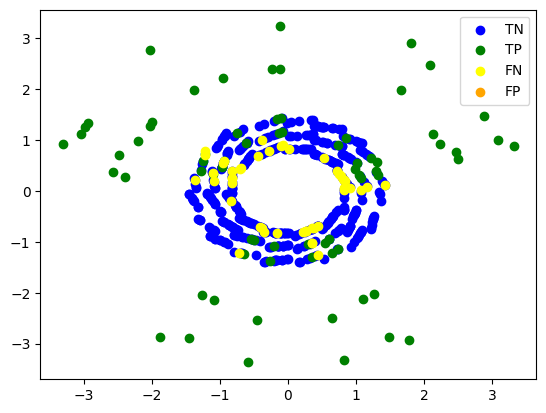

In [29]:
for batch in tqdm(train_data_loader):
    b = 0
    coords = batch.x[batch.batch == b]
    gt = batch.active_node[batch.batch == b].to(torch.bool)
    x = coords[:, 0]*np.cos(coords[:, 1])
    y = coords[:, 0]*np.sin(coords[:, 1])
    preds = model(batch.to(DEVICE))[batch.batch == b].squeeze(0).cpu() > 0
    print(f'{torch.sum(preds)/preds.shape[0]=}')
    plt.scatter(x[~gt & ~preds], y[~gt & ~preds], color='blue', label='TN')
    plt.scatter(x[gt & preds], y[gt & preds], color='green', label='TP')
    plt.scatter(x[gt & ~preds], y[gt & ~preds], color='yellow', label='FN')
    plt.scatter(x[~gt & preds], y[~gt & preds], color='orange', label='FP')
    plt.legend()



    break

In [77]:
coords[:, 4][coords[:, 4] > 3]

tensor([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 6., 6., 6., 6.,
        6., 6., 6., 6., 6., 6., 6., 6.])

In [41]:
coords = batch.x[batch.batch == 0]
gt = batch.active_node[batch.batch == 0].to(torch.bool)
x = coords[:, 0]*np.cos(coords[:, 1])
y = coords[:, 0]*np.sin(coords[:, 1])
preds = model(batch.to(DEVICE))[batch.batch == 0].squeeze(0).cpu() > 0
plt.scatter(x[~gt & ~preds], y[~gt & ~preds], color='blue')
plt.scatter(x[gt & preds], y[gt & preds], color='red')


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [26]:
(preds <= 0).sum()

811

In [19]:
x[gt].shape

torch.Size([873])

In [15]:
x.shape

torch.Size([873])